# Import Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected"

#machine learning libs
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#tensorflow libraries and deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#scikit learn libraries
from sklearn.model_selection import train_test_split #train test split
from sklearn.metrics import mean_squared_error #mean squared error of the regression
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn import ensemble
import xgboost as xgb
from tabnanny import verbose

c:\Users\hussi\anaconda3\envs\ML\lib\site-packages\xgboost\compat.py:36: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



In [8]:
#setting up the notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#remove warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# West Dover Scraped Properties Data

This dataset consists of real estate transaction records from the West Dover, Vermont region over the past three years. Our aim is to utilize features from Zillow to predict the fair market value of a given property in the area. West Dover is a sought-after location for its picturesque Fall and Winter scenery, as well as its proximity to the Mount Snow ski resort. The dataset includes data on a total of 513 properties sold between 2020 and 2022, which we will utilize to make informed decisions on purchasing property in the region.

In [9]:
#read dataset from excel file
df = pd.read_excel(r'West_dover_apify.xlsx')

#filter on needed columns only
cols = ['abbreviatedAddress', 'address/city', 'address/zipcode', 'bathrooms', 'bedrooms',
'dateSoldString', 'daysOnZillow', 'description', 'favoriteCount' ,'hoaFee' , 'homeStatus', 'homeType', 'lastSoldPrice', 
'latitude', 'longitude', 'livingArea', 'lotSize', 'mortgageRates/thirtyYearFixedRate', 'pageViewCount', 'postingContact/name', 
'propertyTaxRate', 'taxHistory/0/value', 'yearBuilt']

#filter on needed columns
df1 = df.copy()
df1 = df1.loc[:,cols]

#removing for sale properties since the last sold price is only the price at which it was sold years ago and not the listed price
df1 = df1[~(df1['homeStatus']=='FOR_SALE')]

In [10]:
#show the shape of the data
df.shape

(513, 758)

In [11]:
df1.head()

,abbreviatedAddress,address/city,address/zipcode,bathrooms,bedrooms,dateSoldString,daysOnZillow,description,favoriteCount,hoaFee,homeStatus,homeType,lastSoldPrice,latitude,longitude,livingArea,lotSize,mortgageRates/thirtyYearFixedRate,pageViewCount,postingContact/name,propertyTaxRate,taxHistory/0/value,yearBuilt
0,8E Deer Creek Road UNIT E,West Dover,5356,2.0,3.0,NaN,1.0,"3 Bedroom 2 bath, top level and a great price!...",17.0,NaN,RECENTLY_SOLD,CONDO,349000.0,42.962830,-72.889040,1024.0,NaN,5.418,300.0,Sheila Joyce-Albano,1.84,153000.0,1989.0
7,28A Crosstown Road,West Dover,5356,2.0,4.0,NaN,0.0,Spacious 3 bedroom plus loft townhome just dow...,1.0,NaN,RECENTLY_SOLD,CONDO,350000.0,42.974842,-72.890920,1696.0,NaN,5.418,42.0,Adam Palmiter,1.84,NaN,1986.0
9,202 Blue Brook Road,West Dover,5356,2.0,3.0,NaN,0.0,"A cozy, charming, well-kept 3 bedroom, 2 bath ...",3.0,NaN,RECENTLY_SOLD,SINGLE_FAMILY,329000.0,42.972470,-72.872090,1532.0,23087.0,5.418,152.0,Regina Perrotto,1.84,191460.0,1960.0
12,734 VT Route 100,Wilmington,5363,1.0,2.0,2022-07-06,65.0,So many potential uses for this versatile prop...,NaN,NaN,RECENTLY_SOLD,SINGLE_FAMILY,200000.0,42.910248,-72.845870,700.0,301870.0,5.774,NaN,Jacki Murano,1.84,95000.0,1977.0
13,12 Timberview Road,West Dover,5356,NaN,NaN,2022-09-01,8.0,1.3 acre lot in a quiet location not too far f...,NaN,NaN,RECENTLY_SOLD,LOT,11000.0,42.937630,-72.811356,NaN,57934.0,NaN,NaN,Chad Lackey,1.84,7900.0,NaN


The dataset is mostly composed of condos, single family homes and lots sold. 

<BarContainer object of 7 artists>

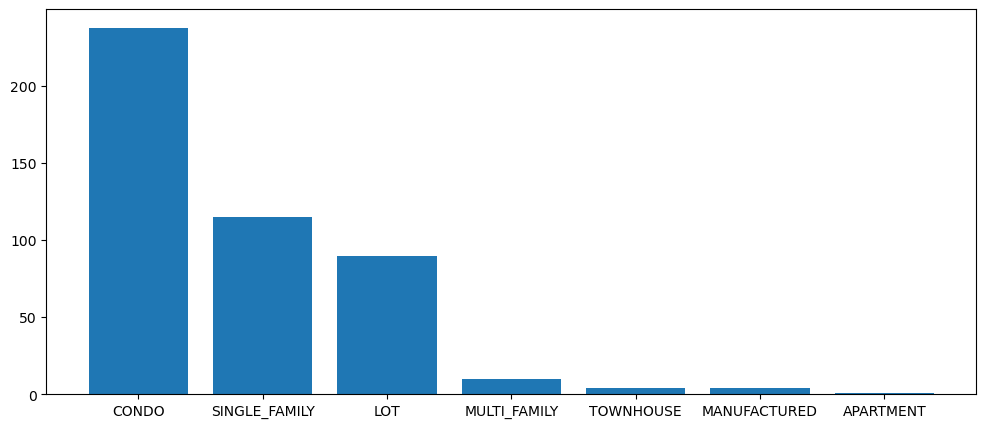

In [12]:
plt.figure(figsize=(12,5))
plt.bar(x= df1['homeType'].unique(), height =df1[['homeType']].value_counts())

# Feature Engineering and data preparation
In this step, we will prepare and format the data for use in machine learning models. We will begin by converting the date sold attribute to a Pandas datetime and extracting the sold year and sold month from the date column. We will also consider adding additional features such as total rooms, favoritePerView, age, sqft/room, and price/sqft. Finally, we will use a K-means algorithm to cluster each unit based on its longitude and latitude into eight clusters. The number of clusters was chosen based on the improvement in model accuracy.

In [13]:
###################### DATE TIME FEATURES #################################################################
df1.loc[:,'dateSoldString'] = pd.to_datetime(df1['dateSoldString'], format="%Y-%m-%d") #to date time format
df1['soldYear'] = df1['dateSoldString'].dt.year #get the year
df1['soldMonth'] = df1['dateSoldString'].dt.month #get the month

#################### OTHER FEATURES ################################################################
df1['totalRooms'] = df1['bedrooms'] + df1['bathrooms'] #add a new feature
df1['favoritePerView'] = df1['pageViewCount'] / df1['favoriteCount'] #add a new feature
df1['Age'] = 2022 - df1['yearBuilt'] #add a new feature
df1['Sqft/room'] = df1['livingArea']/df1['totalRooms']
df1['Price/Sqft'] = df1['lastSoldPrice']/df1['livingArea']

########################## LOCATION FEATURES ############################################
cluster_features = df1[['longitude', 'latitude']]
#scale features
minmaxscaler = StandardScaler()
transformed_features = minmaxscaler.fit_transform(cluster_features)
#run clustering algorithm
km = KMeans(init="k-means++", n_clusters=8, n_init=11, random_state=0 )
#fit the dataset to the algorithm
km.fit(transformed_features)
labels = km.labels_
km.labels_
df1['Location cluster'] = labels 
df1['Location cluster'] = df1['Location cluster'].astype('str')

Here, we visualize the clusters on a map. 

In [14]:
################################ Vizulaizing the Clusters ###########################################################
mapbox_api_key = "pk.eyJ1IjoiaHVzc2Vpbm1vaGFtZWQiLCJhIjoiY2w1MXk3cWNhMDdpNzNqb2NiN3VoNDZycyJ9.ggqfCgSW64ZyD5JnXZ1QGA"
import plotly.io as pio
pio.renderers.default = "notebook_connected"

# set mapbox key
px.set_mapbox_access_token(mapbox_api_key)
# create scatter plot
fig = px.scatter_mapbox(
    df1, 
    lat="latitude", 
    lon="longitude",
    color='Location cluster',
    hover_name='abbreviatedAddress',
    size='lastSoldPrice',
    zoom=13
)
# modify height to show all of (town specific)
fig.update_layout(
    height=800,
    width=900
)
fig.show()

# Data Exploration

#### What is the relationship between Price/Sqft and Year Sold? 
There's a strong positive correlation between the time a property was sold and its price per square foot. In fact, the median price per square foot saw a significant increase of 23% from 2020 to 2022. Additionally, when comparing the 75th percentile, we see that in 2022, 75% of properties sold for a price per square foot of less than $284, compared to just 67% in 2021. 

In [15]:
#What is the average number of bedrooms  sold in West Dover VT?
px.box(df1, x='soldYear', y='Price/Sqft', title='Price/Sqft for each cluster')

#### What is the relationship between Price/Sqft and the Location Cluster?
It appears that the price per square foot of properties doesn't vary significantly across most locations, but there are a couple of exceptions. Clusters 3 and 5, which correspond to the Wilmington area, seem to offer higher prices for properties with more square footage. 

In [16]:
px.box(df1, x='Location cluster', y='Price/Sqft', range_x=[-1,8])

#### What is the relationship between the Living Area and the Sold Price?
The data suggests that this relationship is non-linear, with the sold price becoming less sensitive to the size of a property beyond 3,000 square feet. This is evident when examining the regression lines and the distortion that occurs as the property size increases. On the other hand, homes with sizes less than 3,000 square feet tend to fit well around the regression line, indicating that the sold price is more sensitive to the size of the property in this range. This is a valuable insight that could be useful for anyone looking to buy or sell real estate in the area.

In [17]:
px.scatter(df1, x="livingArea", y="lastSoldPrice", color="homeType", log_x=True, trendline='ols')

# Prepare dataset for a Xtreme Gradient Boosting Algorithm (XGB Boost)
We will clean the dataset to prepare it for training using these steps:
1. Filter the data on needed features, not all features are required. 
2. Drop rows with lots of missing data, and fill rows with missing data using interpolation. 
3. One hot encode categorical features. 
4. Remove outliers to improve forecast accuracy.
5. Remove NaN values. 

In [18]:
#Step 1 - Filter the data on needed features and name it "analysis_df"
selected_features = [ 'homeType', 'bathrooms', 'bedrooms', 'livingArea', 'Age', 'totalRooms', 'soldYear', 'soldMonth', 'lastSoldPrice', 'Location cluster'] #select predictor features
selected_features_2 = [ 'homeType', 'bathrooms', 'bedrooms', 'livingArea', 'Age', 'totalRooms', 'soldYear', 'soldMonth', 'lastSoldPrice', 'longitude', 'latitude'] #select predictor
analysis_df = df1.copy()
analysis_df = analysis_df[selected_features_2]

In [19]:
#In most cases, if the feature bedrooms is missing, all other features are also missing, so we drop any row that has bedrooms missing. 
analysis_df = analysis_df[(analysis_df['bedrooms'].notna()) & (analysis_df['lastSoldPrice'].notna())] 

In [20]:
#lets check which other features contains missing values
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 512
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   homeType       304 non-null    object 
 1   bathrooms      304 non-null    float64
 2   bedrooms       304 non-null    float64
 3   livingArea     303 non-null    float64
 4   Age            283 non-null    float64
 5   totalRooms     304 non-null    float64
 6   soldYear       264 non-null    float64
 7   soldMonth      264 non-null    float64
 8   lastSoldPrice  304 non-null    float64
 9   longitude      304 non-null    float64
 10  latitude       304 non-null    float64
dtypes: float64(10), object(1)
memory usage: 28.5+ KB


In [21]:
#we can use na filling methods from pandas library to fill the missing values in here
analysis_df['livingArea'].interpolate(method='linear', inplace=True, limit_direction='both')
analysis_df['Age'].interpolate(method='linear', inplace=True, limit_direction='both')
analysis_df['soldYear'].fillna(2022,inplace=True)
analysis_df['soldMonth'].fillna(8, inplace=True)

In [22]:
#lets check now if there are still missing values
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304 entries, 0 to 512
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   homeType       304 non-null    object 
 1   bathrooms      304 non-null    float64
 2   bedrooms       304 non-null    float64
 3   livingArea     304 non-null    float64
 4   Age            304 non-null    float64
 5   totalRooms     304 non-null    float64
 6   soldYear       304 non-null    float64
 7   soldMonth      304 non-null    float64
 8   lastSoldPrice  304 non-null    float64
 9   longitude      304 non-null    float64
 10  latitude       304 non-null    float64
dtypes: float64(10), object(1)
memory usage: 28.5+ KB


In [23]:
#one hot encoding of categorial feature home type
analysis_df = pd.get_dummies(analysis_df, columns= ['homeType'], prefix=None).reset_index(drop=True)
#see first five rows
analysis_df.head()

,bathrooms,bedrooms,livingArea,Age,totalRooms,soldYear,soldMonth,lastSoldPrice,longitude,latitude,homeType_APARTMENT,homeType_CONDO,homeType_MANUFACTURED,homeType_MULTI_FAMILY,homeType_SINGLE_FAMILY,homeType_TOWNHOUSE
0,2.0,3.0,1024.0,33.0,5.0,2022.0,8.0,349000.0,-72.88904,42.962830,0,1,0,0,0,0
1,2.0,4.0,1696.0,36.0,6.0,2022.0,8.0,350000.0,-72.89092,42.974842,0,1,0,0,0,0
2,2.0,3.0,1532.0,62.0,5.0,2022.0,8.0,329000.0,-72.87209,42.972470,0,0,0,0,1,0
3,1.0,2.0,700.0,45.0,3.0,2022.0,7.0,200000.0,-72.84587,42.910248,0,0,0,0,1,0
4,2.0,3.0,1800.0,50.0,5.0,2022.0,5.0,320000.0,-72.89414,42.898968,0,0,0,0,1,0


In [24]:
#removing outliers from Living Area
remove = (analysis_df['livingArea']>3001 ) | (analysis_df['livingArea']<600)| (analysis_df['Age']>75) | (analysis_df['totalRooms']>12) | (analysis_df['lastSoldPrice']< 100000)
analysis_df = analysis_df[~remove].reset_index(drop=True)

# Split data into Train and Test Sets

In [25]:
y = analysis_df.copy().pop('lastSoldPrice')
X = analysis_df.copy().drop(['lastSoldPrice'], axis=1)

#original random state = 1000
X_train, X_test, y_train, y_test, = train_test_split(X,y, test_size=0.20, random_state = 1000) #split the data
print("X_train shape", X_train.shape)
print("X test shape", X_test.shape)
print("y train", y_train.shape)
print("y test", y_test.shape)

X_train shape (175, 15)
X test shape (44, 15)
y train (175,)
y test (44,)


# Training XG Boost (no cluster, regularized, max depth =6)
In this step we train the XG boost algorithm on our cleaned dataset using a max depth of 6 trees with regularization. Our loss function will "Mean Squared Error" and our evaluation metric will be "Mean Absolute Error", we will run 16 boost iterations to until we the model converges. We have tried adjusting the parameters to find better methods to reduce the error on the evaluation set (Test set), but couldn't get better performance. In the next step we will conduct error analysis to understand on what features is our property making large errors. That way we can supply the model with more data of those features that could help us make better generalized predictions. 

In [26]:
dtrain = xgb.DMatrix(X_train, y_train) #train set
dtest = xgb.DMatrix(X_test, y_test) #validation set

#specify the parameters
param = {"max_depth": 6, "objective":"reg:squarederror", "lambda":0.01, "alpha":0.01, "seed":1234, "eval_metric":'mae'}

# specify validations set to watch performance
watchlist = [(dtest, "eval"), (dtrain, "train")]

num_round = 16
bst = xgb.train(param, dtrain, num_boost_round=num_round, evals=watchlist)

# run prediction
preds = bst.predict(dtest)
labels = dtest.get_label()
print(
    "error=%f"
    % (
        sum(1 for i in range(len(preds)) if int(preds[i] > 0.5) != labels[i])
        / float(len(preds))
    )
)

[0]	eval-mae:240263.45312	train-mae:232871.84375
[1]	eval-mae:171524.87500	train-mae:163219.96875
[2]	eval-mae:128707.40625	train-mae:114405.16406
[3]	eval-mae:107896.28125	train-mae:80365.20312
[4]	eval-mae:95609.13281	train-mae:56781.81250
[5]	eval-mae:84649.66406	train-mae:40444.46875
[6]	eval-mae:78973.17969	train-mae:29104.27148
[7]	eval-mae:74269.87500	train-mae:21384.08789
[8]	eval-mae:72261.72656	train-mae:16639.24219
[9]	eval-mae:70499.85156	train-mae:13164.10547
[10]	eval-mae:69984.92969	train-mae:11364.90625
[11]	eval-mae:69296.24219	train-mae:9606.05371
[12]	eval-mae:69268.71875	train-mae:8045.34912
[13]	eval-mae:69387.21094	train-mae:6941.51074
[14]	eval-mae:69401.21875	train-mae:6303.78662
[15]	eval-mae:69245.47656	train-mae:5492.47022
error=1.000000


# Predict The Target Value of A Property

In [27]:
#predict our cluster based on latitude and longtiude information
property_coordinates = np.array([[-72.88869908, 42.962726, ]])
property_coordinates = minmaxscaler.transform(property_coordinates)
cluster = km.predict(property_coordinates)[0]
# tgt_home = pd.DataFrame([{"bathrooms":2, "bedrooms":3, "livingArea":1020 , "Age":34,
#                           "totalRooms":5, "soldYear":2022, "soldMonth":10, 
#                            "homeType_APARTMENT":0, "homeType_CONDO":1,
#                           "homeType_MANUFACTURED":0, "homeType_MULTI_FAMILY":0, "homeType_SINGLE_FAMILY":0,
#                           "homeType_TOWNHOUSE":0, 
#                          'Location cluster_0':0, 'Location cluster_1':0, 'Location cluster_2':0,
#                           'Location cluster_3':1, 'Location cluster_4':0, 'Location cluster_5':0, 
#                           'Location cluster_6':0, 'Location cluster_7':0}])

#Insert features about the target home

tgt_home = pd.DataFrame([{"bathrooms":2, "bedrooms":3, "livingArea":1020 , "Age":34,
                          "totalRooms":5, "soldYear":2022, "soldMonth":10, 'longitude':-72.88904, 'latitude':42.96283,
                           "homeType_APARTMENT":0, "homeType_CONDO":1,
                          "homeType_MANUFACTURED":0, "homeType_MULTI_FAMILY":0, "homeType_SINGLE_FAMILY":0,
                          "homeType_TOWNHOUSE":0 }])
tgt_home = xgb.DMatrix(tgt_home)

print('Based on comps in this area, this property should be sold at a price of:' , '$',bst.predict(tgt_home)[0])
# print('Your home belongs to cluster:', cluster)

Based on comps in this area, this property should be sold at a price of: $ 311091.47


# Error Analysis
In this step, we create a dataframe with the actual home price, the predicted price and the error. The goal of this is to focus on homes with prediction errors of more than $50K and determine the drivers behind the large errors. We do that by splitting the dataset into large error dataframe and small error dataframe and running summary statistics on both using the Pandas describe method. We find that there are no clear attributes that seem to differentiate both datasets, which means that other features not captured in our dataset could explain why our model is making large errors on certain homes. 

In [57]:
#Use X_train to make yhat predictions
yhat = bst.predict(xgb.DMatrix(X_test))

#The error is the absolute value between what the model predicted and what the actual home price is 
err = abs(y_test - yhat)

#We create a dataframe with the actual home price, the predicted price and the error 
err_df = X_test.copy()
err_df["home price"] = y_test
err_df["prediction"] = yhat 
err_df['error'] = err 
err_df.head()

large_err_df = err_df[abs(err_df['error']) > 50000] #dataset of large errors
small_err_df = err_df[abs(err_df['error']) < 50000] #dataset of large errors

In [58]:
large_err_df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,20.0,2.650000,0.587143,2.00000,2.000000,3.000000,3.000000,4.00000
bedrooms,20.0,3.550000,0.825578,3.00000,3.000000,3.000000,4.000000,6.00000
livingArea,20.0,2088.850000,526.428110,1100.00000,1755.500000,1928.500000,2513.000000,3000.00000
Age,20.0,33.825000,13.216094,10.00000,21.000000,37.000000,44.000000,52.00000
totalRooms,20.0,6.200000,1.105013,5.00000,5.750000,6.000000,6.250000,9.00000
soldYear,20.0,2021.300000,0.801315,2020.00000,2021.000000,2021.500000,2022.000000,2022.00000
soldMonth,20.0,8.300000,2.386365,1.00000,8.000000,8.000000,10.000000,11.00000
longitude,20.0,-72.863485,0.028686,-72.89521,-72.884121,-72.879170,-72.848508,-72.80673
latitude,20.0,42.944347,0.022889,42.89793,42.929234,42.949314,42.955863,42.98018
homeType_APARTMENT,20.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000


In [59]:
small_err_df.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,24.0,2.375000,0.875388,0.000000,2.000000,2.500000,3.000000,4.00000
bedrooms,24.0,3.625000,0.923721,2.000000,3.000000,3.000000,4.000000,6.00000
livingArea,24.0,1803.458333,506.929373,859.000000,1330.000000,1954.500000,2125.750000,2673.00000
Age,24.0,37.895833,13.183677,12.000000,34.187500,37.250000,42.000000,72.00000
totalRooms,24.0,6.000000,1.318761,4.000000,5.000000,6.000000,7.000000,8.00000
soldYear,24.0,2020.833333,0.816497,2020.000000,2020.000000,2021.000000,2021.250000,2022.00000
soldMonth,24.0,6.875000,2.112334,3.000000,6.000000,7.000000,8.000000,12.00000
longitude,24.0,-72.860055,0.024540,-72.893040,-72.877965,-72.864087,-72.848769,-72.81095
latitude,24.0,42.944351,0.020576,42.898090,42.932108,42.948828,42.956476,42.97618
homeType_APARTMENT,24.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


# Making Predictions using Neural Networks
NN are usually better with larger datasets, but we will try them anyways. In this step, we normalize the input features for faster computation and feed the features to a simple neural network with 9 hidden layers and 1 output layer using the relu activation function. We also reguarize the weights to avoid overfitting. For the loss function we use mean squared error and evaluate the performance using the MAPE. Typically a MAPE below 20% shows that the model performs well. We run the model for 700 epochs. 

In [32]:
X_train_neural = X_train.copy().reset_index(drop=True)
X_test_neural = X_test.copy().reset_index(drop=True)
X_train_neural.shape

(175, 15)

In [33]:
layer = tf.keras.layers.Normalization(axis=None) #normalization layer in tensorflow
layer.adapt(X_train_neural) #learns the mean and variance of the X features
X_train_neural= layer(X_train_neural)
X_test_neural = layer(X_test_neural)


In [60]:
tf.random.set_seed(1234) #applied to achieve consistent results

#set up sequential layers of type Dense
def simple_nn(alpha):
    model = Sequential( 
        [
            #specifies the expected shape of the input. This allows Tf to size the weights and bias parameters at this point. This statement can be omitted in practice and tensorflow will size the network parameters when the input data is specified in the model.fit statement #this is a Dense network layer, first layer, with three neurons or units,
            Dense(6, activation='relu', name='layer3', kernel_regularizer = tf.keras.regularizers.L2(alpha)),
            Dense(3, activation='relu', name='layer2', kernel_regularizer = tf.keras.regularizers.L2(alpha)), 
            Dense(1, activation='relu', name='outputlayer')
        ])

    #setting up the loss function and the optimizer
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

    #fit the model
    history = model.fit(X_train_neural, y_train, verbose=0 , epochs=700, validation_split= 0.33) #surpress logging using verbose

    return model, history

#run the model 
snn_model = simple_nn(0.001)[0] #takes about 31.2 seconds to run

We can see that the model has a MAPE of 33.7% of training set and 35% on test set, this indicates that the model does not overfit, but doesn't perform as good as we would like. For better performance, we would have to feed the data with more features or more data points so it can learn more patterns of those unique homes. 

In [62]:
#train error
snn_model.evaluate(X_train_neural, y_train)

6/6 [==============================] - 0s 3ms/step - loss: 14711073792.0000 - mean_absolute_percentage_error: 33.7741


[14711073792.0, 33.77412796020508]

In [63]:
#test error
snn_model.evaluate(x=X_test_neural, y=y_test, verbose=1)

2/2 [==============================] - 0s 4ms/step - loss: 17222072320.0000 - mean_absolute_percentage_error: 34.9583


[17222072320.0, 34.958335876464844]

In [38]:
#metric names
snn_model.metrics_names

['loss', 'mean_absolute_percentage_error']

# Predict target home using NN.

In [64]:
# tgt_home_neural = pd.DataFrame([{"bathrooms":2, "bedrooms":3, "livingArea":1020 , "Age":34,
#                           "totalRooms":5, "soldYear":2022, "soldMonth":10, 
#                            "homeType_APARTMENT":0, "homeType_CONDO":1,
#                           "homeType_MANUFACTURED":0, "homeType_MULTI_FAMILY":0, "homeType_SINGLE_FAMILY":0,
#                           "homeType_TOWNHOUSE":0, 
#                          'Location cluster_0':0, 'Location cluster_1':0, 'Location cluster_2':0,
#                           'Location cluster_3':1, 'Location cluster_4':0, 'Location cluster_5':0, 
#                           'Location cluster_6':0, 'Location cluster_7':0}])

tgt_home_neural= pd.DataFrame([{"bathrooms":2, "bedrooms":3, "livingArea":1020 , "Age":34,
                          "totalRooms":5, "soldYear":2022, "soldMonth":10, 'longitude':-72.88904, 'latitude':42.96283,
                           "homeType_APARTMENT":0, "homeType_CONDO":1,
                          "homeType_MANUFACTURED":0, "homeType_MULTI_FAMILY":0, "homeType_SINGLE_FAMILY":0,
                          "homeType_TOWNHOUSE":0 }])

tgt_home_neural = layer(tgt_home_neural)
tgt_home_neural

<tf.Tensor: shape=(1, 15), dtype=float32, numpy=
array([[-0.379277  , -0.3778179 ,  1.1060807 , -0.33258596, -0.37489972,
         2.5680928 , -0.36760423, -0.48854712, -0.31950837, -0.38219517,
        -0.38073608, -0.38219517, -0.38219517, -0.38219517, -0.38219517]],
      dtype=float32)>

In [40]:
print("Your target home should be selling at:", "$",snn_model.predict(tgt_home_neural, verbose=0 )[0][0])

Your target home should be selling at: $ 252713.28
